In [2]:
#import the modules 
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import pandas as pd
import seaborn as sns

from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.inception_v3 import InceptionV3


from keras import Model, layers
from keras.optimizers import Adam
from keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, MaxPooling2D, Flatten, MaxPooling3D

In [3]:
#path of image folders
train = 'dataset/train'
test = 'dataset/test'

train_datagen = ImageDataGenerator( rescale = 1.0/255.,shear_range=0.2,zoom_range=0.2)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

train_generator = train_datagen.flow_from_directory(train,target_size=(224,224),color_mode='rgb',batch_size=32,class_mode='categorical',shuffle=True)
test_generator = train_datagen.flow_from_directory(test,target_size=(224,224),color_mode='rgb',batch_size=1,class_mode='categorical',shuffle=True)

Found 721 images belonging to 4 classes.
Found 352 images belonging to 4 classes.


In [4]:
def save_history(history, model_name):
    #convert the history.history dict to a pandas DataFrame:     
    hist_df = pd.DataFrame(history.history) 

    # save to json:  
    hist_json_file = model_name+'_history.json' 
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)

    # or save to csv: 
    hist_csv_file = model_name+'_history.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
        
def plot_accuracy_from_history(history, isinception=False):
    color = sns.color_palette()
    if(isinception == False):
        acc = history.history['acc']
        val_acc = history.history['val_acc']
    else:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
    

    epochs = range(len(acc))

    sns.lineplot(epochs, acc, label='Training Accuracy')
    sns.lineplot(epochs, val_acc,label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.figure()
    plt.show()
    
def plot_loss_from_history(history):
    color = sns.color_palette()
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(loss))
    
    sns.lineplot(epochs, loss,label='Training Loss')
    sns.lineplot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.figure()
    plt.show()
    
def do_history_stuff(history, history_file_name, isinception=False):
    save_history(history, history_file_name)
    plot_accuracy_from_history(history, isinception)
    plot_loss_from_history(history)


In [5]:
class_dict = train_generator.class_indices
print(class_dict)
class_dict = {values:key for key,values in class_dict.items()}
print(class_dict)

#convert dictionary to list
class_list = [values for _,values in class_dict.items()]
print(class_list)

{'fmd disease': 0, 'healthy skin': 1, 'healthycows': 2, 'lumpycows': 3}
{0: 'fmd disease', 1: 'healthy skin', 2: 'healthycows', 3: 'lumpycows'}
['fmd disease', 'healthy skin', 'healthycows', 'lumpycows']


In [5]:
InceptionV3_model = InceptionV3(input_shape=(224,224,3),weights='imagenet', include_top=False)
for layer in InceptionV3_model.layers[:249]:
   layer.trainable = False
for layer in InceptionV3_model.layers[249:]:
   layer.trainable = True
InceptionV3_last_output = InceptionV3_model.output
InceptionV3_maxpooled_output = Flatten()(InceptionV3_last_output)
InceptionV3_x = Dense(1024, activation='relu')(InceptionV3_maxpooled_output)
InceptionV3_x = Dropout(0.5)(InceptionV3_x)
InceptionV3_x = Dense(4, activation='softmax')(InceptionV3_x)
InceptionV3_x_final_model = Model(inputs=InceptionV3_model.input,outputs=InceptionV3_x)
InceptionV3_x_final_model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy',metrics=['accuracy'])

inception_filepath = 'inceptionv3_'+'-saved-model-{epoch:02d}-loss-{loss:.2f}.hdf5'
inception_checkpoint = tf.keras.callbacks.ModelCheckpoint(inception_filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
inception_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)





C:\Users\akash\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [6]:
inceptionv3_history = InceptionV3_x_final_model.fit(train_generator, epochs = 10, validation_data = test_generator,callbacks=[inception_checkpoint,inception_early_stopping],verbose=1)


Epoch 1/10
23/23 [==============================] - 58s 2s/step - loss: 2.1622 - accuracy: 0.5687 - val_loss: 3.9072 - val_accuracy: 0.5426
Epoch 2/10
23/23 [==============================] - 51s 2s/step - loss: 0.4932 - accuracy: 0.8336 - val_loss: 1.4133 - val_accuracy: 0.7159
Epoch 3/10
23/23 [==============================] - 50s 2s/step - loss: 0.1789 - accuracy: 0.9390 - val_loss: 1.5333 - val_accuracy: 0.7045
Epoch 4/10
23/23 [==============================] - 50s 2s/step - loss: 0.1367 - accuracy: 0.9487 - val_loss: 2.0877 - val_accuracy: 0.6278
Epoch 5/10
23/23 [==============================] - 50s 2s/step - loss: 0.0894 - accuracy: 0.9750 - val_loss: 2.0405 - val_accuracy: 0.6562
Epoch 6/10
23/23 [==============================] - 50s 2s/step - loss: 0.0835 - accuracy: 0.9667 - val_loss: 1.7699 - val_accuracy: 0.6989
Epoch 7/10
23/23 [==============================] - 49s 2s/step - loss: 0.0612 - accuracy: 0.9750 - val_loss: 1.6114 - val_accuracy: 0.7386
Epoch 8/10
23/23 [==

C:\Users\akash\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\akash\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


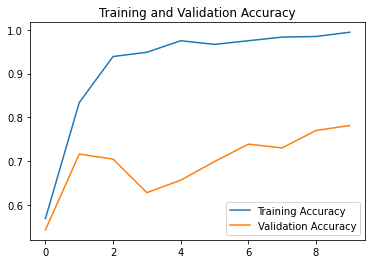

<Figure size 432x288 with 0 Axes>

C:\Users\akash\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\akash\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


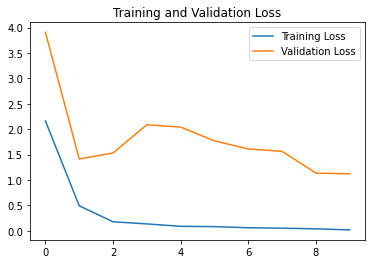

<Figure size 432x288 with 0 Axes>

In [7]:
do_history_stuff(inceptionv3_history, 'inceptionv3_model', True)  

In [8]:
from keras.utils import plot_model
from sklearn.metrics import classification_report
from collections import Counter
import random
import os
import cv2
from IPython.display import Image

In [9]:
true_value = []
inception_pred = []

for folder in os.listdir(test):
    
    test_image_ids = os.listdir(os.path.join(test,folder))
    
    for image_id in test_image_ids[:int(len(test_image_ids))]:
        
        path = os.path.join(test,folder,image_id)
        
        true_value.append(test_generator.class_indices[folder])
        img = cv2.resize(cv2.imread(path),(224,224))
        img_normalized = img/255
       
        #Inception
        inception_image_prediction = np.argmax(InceptionV3_x_final_model.predict(np.array([img_normalized])))
        inception_pred.append(inception_image_prediction)
        
    

1/1 [==============================] - 0s 62ms/step


1/1 [==============================] - 0s 63ms/step


In [10]:
from sklearn.metrics import confusion_matrix
import itertools
#from mlxtend.plotting import plot_confusion_matrix
def clf_report(true_value, model_pred):
    
    classes = test_generator.class_indices.keys()
    TP_count = [true_value[i] == model_pred[i] for i in range(len(true_value))]
    model_accuracy = np.sum(TP_count)/len(TP_count)
    print('Model Accuracy', model_accuracy)
    
    plt.figure(figsize=(7,7))
    cm = confusion_matrix(true_value,model_pred)
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.viridis)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()*0.8
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="black" if cm[i,j] > thresh else "white")
        pass
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass
    
    print(classification_report(true_value, model_pred, target_names = list(classes)))
    

Model Accuracy 0.7727272727272727
              precision    recall  f1-score   support

disease skin       0.75      0.60      0.67        15
healthy skin       0.69      0.65      0.67        17
 healthycows       0.76      0.82      0.79       155
   lumpycows       0.80      0.76      0.78       165

    accuracy                           0.77       352
   macro avg       0.75      0.71      0.72       352
weighted avg       0.77      0.77      0.77       352



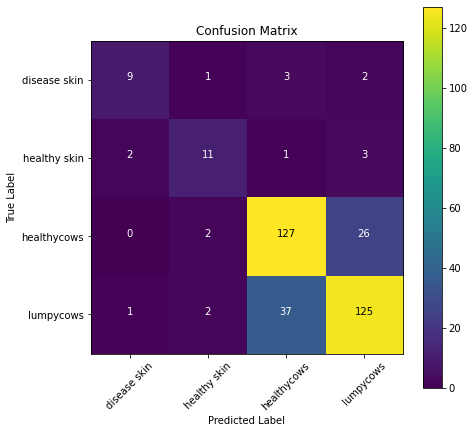

In [11]:
clf_report(true_value, inception_pred)

In [12]:
InceptionV3_x_final_model.save('inception-10.h5')

In [13]:
inceptionv3_history = InceptionV3_x_final_model.fit(train_generator, epochs = 10, validation_data = test_generator,callbacks=[inception_checkpoint,inception_early_stopping],verbose=1)


Epoch 1/10
23/23 [==============================] - 51s 2s/step - loss: 0.0115 - accuracy: 0.9958 - val_loss: 1.1358 - val_accuracy: 0.7642
Epoch 2/10
23/23 [==============================] - 50s 2s/step - loss: 0.0133 - accuracy: 0.9945 - val_loss: 1.1577 - val_accuracy: 0.7670
Epoch 3/10
23/23 [==============================] - 49s 2s/step - loss: 0.0086 - accuracy: 0.9958 - val_loss: 1.2062 - val_accuracy: 0.7614
Epoch 4/10
23/23 [==============================] - 49s 2s/step - loss: 0.0150 - accuracy: 0.9945 - val_loss: 1.1767 - val_accuracy: 0.7528
Epoch 5/10
23/23 [==============================] - 50s 2s/step - loss: 0.0332 - accuracy: 0.9875 - val_loss: 1.5821 - val_accuracy: 0.6932
Epoch 6/10
23/23 [==============================] - 50s 2s/step - loss: 0.0125 - accuracy: 0.9958 - val_loss: 1.5810 - val_accuracy: 0.7670
Epoch 7/10
23/23 [==============================] - 49s 2s/step - loss: 0.0101 - accuracy: 0.9958 - val_loss: 1.3827 - val_accuracy: 0.7812
Epoch 8/10
23/23 [==

C:\Users\akash\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\akash\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


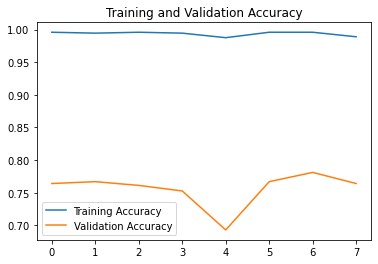

<Figure size 432x288 with 0 Axes>

C:\Users\akash\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\akash\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


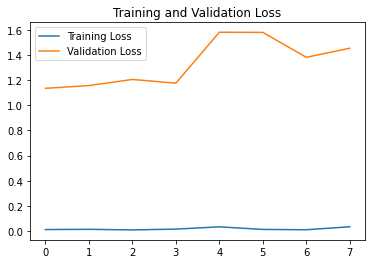

<Figure size 432x288 with 0 Axes>

In [14]:
do_history_stuff(inceptionv3_history, 'inceptionv3_model', True)  

In [15]:
true_value = []
inception_pred = []

for folder in os.listdir(test):
    
    test_image_ids = os.listdir(os.path.join(test,folder))
    
    for image_id in test_image_ids[:int(len(test_image_ids))]:
        
        path = os.path.join(test,folder,image_id)
        
        true_value.append(test_generator.class_indices[folder])
        img = cv2.resize(cv2.imread(path),(224,224))
        img_normalized = img/255
       
        #Inception
        inception_image_prediction = np.argmax(InceptionV3_x_final_model.predict(np.array([img_normalized])))
        inception_pred.append(inception_image_prediction)
        
    

1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 66ms/step


In [16]:
from sklearn.metrics import confusion_matrix
import itertools
#from mlxtend.plotting import plot_confusion_matrix
def clf_report(true_value, model_pred):
    
    classes = test_generator.class_indices.keys()
    TP_count = [true_value[i] == model_pred[i] for i in range(len(true_value))]
    model_accuracy = np.sum(TP_count)/len(TP_count)
    print('Model Accuracy', model_accuracy)
    
    plt.figure(figsize=(7,7))
    cm = confusion_matrix(true_value,model_pred)
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.viridis)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()*0.8
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="black" if cm[i,j] > thresh else "white")
        pass
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass
    
    print(classification_report(true_value, model_pred, target_names = list(classes)))
    

Model Accuracy 0.7755681818181818
              precision    recall  f1-score   support

disease skin       0.64      0.60      0.62        15
healthy skin       0.69      0.65      0.67        17
 healthycows       0.73      0.89      0.80       155
   lumpycows       0.87      0.70      0.77       165

    accuracy                           0.78       352
   macro avg       0.73      0.71      0.72       352
weighted avg       0.79      0.78      0.77       352



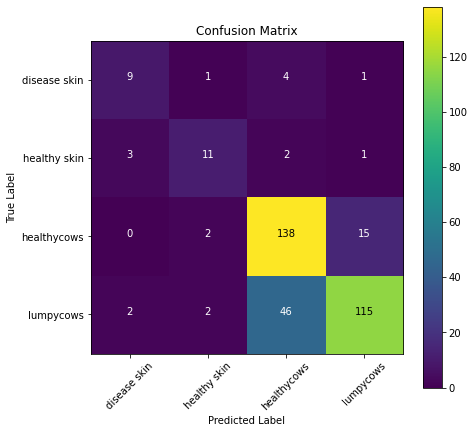

In [17]:
clf_report(true_value, inception_pred)

In [18]:
model = tf.keras.models.load_model('inception-10.h5')

In [35]:
path = 'dataset/test/disease skin/Screenshot 2022-12-18 211253.jpg'
path1='dataset/test/disease skin/Screenshot 2022-12-18 211218.jpg'

In [36]:
import cv2

In [37]:
img = cv2.resize(cv2.imread(path),(224,224))
img_normalized = img/255

In [38]:
img1 = cv2.resize(cv2.imread(path1),(224,224))
img_normalized1 = img1/255

In [39]:
inception_image_prediction = np.argmax(model.predict(np.array([img_normalized])))

1/1 [==============================] - 0s 133ms/step


In [40]:
inception_image_prediction1 = np.argmax(model.predict(np.array([img_normalized1])))

1/1 [==============================] - 0s 118ms/step


In [41]:
print(class_list[inception_image_prediction])

disease skin


In [42]:
print(class_list[inception_image_prediction1])

disease skin


In [43]:
path = 'dataset/test/lumpycows/img1280.jpg'
path1='dataset/test/lumpycows/img1413.jpg'

In [44]:
img = cv2.resize(cv2.imread(path),(224,224))
img_normalized = img/255

In [45]:
img1 = cv2.resize(cv2.imread(path1),(224,224))
img_normalized1 = img1/255

In [46]:
inception_image_prediction = np.argmax(model.predict(np.array([img_normalized])))

1/1 [==============================] - 0s 105ms/step


In [47]:
inception_image_prediction1 = np.argmax(model.predict(np.array([img_normalized1])))

1/1 [==============================] - 0s 99ms/step


In [48]:
print(class_list[inception_image_prediction])

lumpycows


In [49]:
print(class_list[inception_image_prediction1])

lumpycows
